In [1]:
import os
import cv2
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
from SqueezeDetHelpers import get_all_points_from_prediction
from Models.PoolingAndFire import create_loss_function_multiple_detection
from PreProcess import *

In [3]:
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points_multi_gpu.h5py")
MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points_overfit_sample0_earlystop.h5py")
RHD_ANNOTATIONS_FILE = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/anno_training.pickle")
VALIDATION_DIR = os.path.expanduser("~/datasets/RHD/processed/validation")
TRAIN_DIR = os.path.expanduser("~/datasets/RHD/processed/train")
VALIDATION_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/validation/annotations/")
TRAIN_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/train/annotations/")

In [4]:
create_rhd_annotations(RHD_ANNOTATIONS_FILE,
                       VALIDATION_ANNOTATIONS,
                       VALIDATION_DIR,
                       fingers='ALL',
                       hands_to_annotate='BOTH',
                       annotate_non_visible=False,
                       force_new_files=True)

  1%|▏         | 532/41259 [00:00<00:07, 5315.13it/s]

Creating annotations in directory: /home/clh/datasets/RHD/processed/validation
Using annotation file: /home/clh/datasets/RHD/RHD_published_v2/training/anno_training.pickle
And outputting to: /home/clh/datasets/RHD/processed/validation/annotations/


100%|██████████| 41259/41259 [00:08<00:00, 4664.13it/s]

In [5]:
BATCHSIZE = 64
EPSILON = 1e-16

LABEL_WEIGHT = 1.0
OFFSET_LOSS_WEIGHT = 1.0
OFFSET_SCALE = int(320 / 20) / 2

NUM_CLASSES = 42

l = create_loss_function_multiple_detection(20,
                                            20,
                                            LABEL_WEIGHT,
                                            OFFSET_SCALE,
                                            OFFSET_LOSS_WEIGHT,
                                            NUM_CLASSES,
                                            EPSILON,
                                            BATCHSIZE)

In [6]:
model = load_model(MODEL_FILE, custom_objects={'loss_function': l})

In [7]:
NUM_SAMPLES_TO_CHECK = 10

samples_to_check = []
for fi in os.listdir(TRAIN_DIR):
    if fi.endswith('png'):
        samples_to_check.append(int(fi.split('.')[0]))
        if len(samples_to_check) >= NUM_SAMPLES_TO_CHECK:
            break

print(samples_to_check)

[0]


In [8]:
#labels, images = load_data_with_anchors(samples_to_check,
#                                        DATA_DIR,
#                                        ANNOTATIONS_PATH,
#                                        320, 320,
#                                        20, 20,
#                                        'png',
#                                        num_classes=NUM_CLASSES)

#overfit_sample = [0]
#samples_to_check = overfit_sample
labels, images = load_data_with_anchors(samples_to_check,
                                        TRAIN_DIR,
                                        TRAIN_ANNOTATIONS,
                                        320, 320,
                                        20, 20,
                                        OFFSET_SCALE,
                                        'png',
                                        num_classes=NUM_CLASSES,
                                        greyscale=True)

images_show = np.zeros((len(images), 320, 320, 3), dtype=np.uint8)
for c, im in enumerate(images):
    #images_show[c] = cv2.cvtColor((im * 255.0).astype(np.uint8), cv2.COLOR_BGR2RGB)
    images_show[c][:, :, 0] = im.reshape(320, 320) * 255.0
    images_show[c][:, :, 1] = im.reshape(320, 320) * 255.0
    images_show[c][:, :, 2] = im.reshape(320, 320) * 255.0

print(np.max(images[0]))

0.9176470588235294


In [9]:

for l in labels:
    print(l.shape)
    for i in range(NUM_CLASSES):
        offset_xs = l[:, :, NUM_CLASSES+i*2]
        offset_ys = l[:, :, NUM_CLASSES+1+i*2]
        
        print(f"Offset max x: {np.max(offset_xs)}")
        print(f"Offset max y: {np.max(offset_ys)}")
        print("")

(20, 20, 126)
Offset max x: 0.08749961853027344
Offset max y: 0.0625

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.6125001907348633
Offset max y: 0.0

Offset max x: 0.125
Offset max y: 0.7875003814697266

Offset max x: 0.0
Offset max y: 0.3250007629394531

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.6875

Offset max x: 0.0
Offset max y: 0.1875

Offset max x: 0.8874998092651367
Offset max y: 0.0

Offset max x: 0.35000038146972656
Offset max y: 0.0

Offset max x: 0.23750019073486328
Offset max y: 0.0

Offset max x: 0.16250038146972656
Offset max y: 0.46249961853027344

Offset max x: 0.3000001907348633
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.16250038146972656

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.7000007629394531

Offset max x: 0.0
Offset max y: 0.03750038146972656

Offset max x: 0.0
Offset max y: 0.08749961853027344

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0
Offset max y: 0.0

Offset max x: 0.0

In [10]:
right_hand = []
left_hand = []

with open(RHD_ANNOTATIONS_FILE, 'rb') as f:
    annotations = pickle.load(f)
    
for s in samples_to_check:
    right_hand.append(get_right_hand(s, annotations))
    left_hand.append(get_left_hand(s, annotations))

In [11]:
"""
for c, h in enumerate(right_hand):
    for finger, point in h.items():
        p = point[:2]
        if p[0] < 0 or p[1] < 0:
            continue
        print(f"Right hand point: ({p[0]}, {p[1]})")
        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)
    
for c, h in enumerate(left_hand):
    for finger, point in h.items():
        p = point[:2]
        if p[0] < 0 or p[1] < 0:
            continue
        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)
"""

'\nfor c, h in enumerate(right_hand):\n    for finger, point in h.items():\n        p = point[:2]\n        if p[0] < 0 or p[1] < 0:\n            continue\n        print(f"Right hand point: ({p[0]}, {p[1]})")\n        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)\n    \nfor c, h in enumerate(left_hand):\n    for finger, point in h.items():\n        p = point[:2]\n        if p[0] < 0 or p[1] < 0:\n            continue\n        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)\n'

In [12]:
res = []
process_times = []
for im in images:
    before = time.time()
    res.append(model.predict(im.reshape(1, 320, 320, 1)))
    process_times.append(time.time() - before)
    
process_times = np.array(process_times)
print(f"Average processing time: {np.mean(process_times)}")
print(f"Max processing time: {np.max(process_times)}")
print(f"Min processing time: {np.min(process_times)}")
print(f"Average processing time excepting first: {np.mean(process_times[1:])}")

Average processing time: 2.346914291381836
Max processing time: 2.346914291381836
Min processing time: 2.346914291381836
Average processing time excepting first: nan


/home/clh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/clh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
for c, l in enumerate(labels):
    for i in range(NUM_CLASSES):
        single_label = np.zeros((20, 20, 3))
        single_label[:, :, 0] = labels[c, :, :, i]
        single_label[:, :, 1] = labels[c, :, :, NUM_CLASSES+i*2]
        single_label[:, :, 2] = labels[c, :, :, NUM_CLASSES+1+i*2]
        
        anchors = get_anchors(320, 320, 20, 20)

        label_points = get_all_points_from_prediction(single_label,
                                                      anchors,
                                                      threshold=1.0,
                                                      offset_weight=OFFSET_SCALE)
        
        for p in label_points:
            x = p[0] + p[2]
            y = p[1] + p[3]
            
            #print(f"Label point: ({x}, {y})")
            #print(f"\tOffset: ({p[2]}, {p[3]})")
            print(f"Label point: ({x}, {y}), offset: ({p[2]}, {p[3]})")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (0, 255, 0), thickness=2)
        

Label point: (106.69999694824219, 213.5), offset: (0.6999969482421875, 0.5)
Label point: (129.1999969482422, 227.60000610351562), offset: (-7.8000030517578125, -0.399993896484375)
Label point: (125.9000015258789, 225.0), offset: (4.900001525878906, -3.0)
Label point: (122.0, 219.3000030517578), offset: (1.0, 6.3000030517578125)
Label point: (113.9000015258789, 215.60000610351562), offset: (-7.099998474121094, 2.600006103515625)
Label point: (117.19999694824219, 237.3000030517578), offset: (-3.8000030517578125, -5.6999969482421875)
Label point: (115.5, 233.5), offset: (-5.5, 5.5)
Label point: (114.30000305175781, 229.5), offset: (-6.6999969482421875, 1.5)
Label point: (113.0999984741211, 224.60000610351562), offset: (7.099998474121094, -3.399993896484375)
Label point: (108.80000305175781, 241.8000030517578), offset: (2.8000030517578125, -1.1999969482421875)
Label point: (107.9000015258789, 237.10000610351562), offset: (1.9000015258789062, -5.899993896484375)
Label point: (107.3000030517

In [14]:
THRESHOLD = 0.9

for c, r in enumerate(res):
    #print(r.shape)
    #pred = r.reshape(20, 20, 3)
    
    for i in range(NUM_CLASSES):
        pred = np.zeros((20, 20, 3))
        
        pred[:, :, 0] = res[c][:, :, :, i]
        pred[:, :, 1] = res[c][:, :, :, NUM_CLASSES+i*2]
        pred[:, :, 2] = res[c][:, :, :, NUM_CLASSES+1+i*2]
        
        #print(np.max(pred[:, :, 0]))
        
        anchors = get_anchors(320, 320, 20, 20)
        max_val = np.max(pred[:,:,0])
        pred_point = get_all_points_from_prediction(pred,
                                                    anchors,
                                                    threshold=max_val,
                                                    offset_weight=OFFSET_SCALE,
                                                    is_label=False)
        
        for p in pred_point:
            x = p[0] + p[2]
            y = p[1] + p[3]
            
            print(f"Predicted point: ({x}, {y}), confidence: {max_val}")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (255, 0, 0), thickness=1)

Predicted point: (106.69535160064697, 213.57295322418213), confidence: 0.9992221593856812
Predicted point: (129.19652172923088, 227.5942039489746), confidence: 0.9991611242294312
Predicted point: (125.91761779785156, 224.9855194091797), confidence: 0.9995847344398499
Predicted point: (121.96411037445068, 219.29150199890137), confidence: 0.9993917942047119
Predicted point: (113.89258295297623, 215.59381580352783), confidence: 0.9994731545448303
Predicted point: (117.1946473121643, 237.28719186782837), confidence: 0.9991211295127869
Predicted point: (115.48852038383484, 233.51417350769043), confidence: 0.9995610117912292
Predicted point: (114.26245403289795, 229.50622653961182), confidence: 0.9995330572128296
Predicted point: (113.11066436767578, 224.59693384170532), confidence: 0.9995177984237671
Predicted point: (108.81464767456055, 241.78013467788696), confidence: 0.999697208404541
Predicted point: (107.89422607421875, 237.08726024627686), confidence: 0.9996893405914307
Predicted poin

In [15]:
def confidence_score(label, prediction, num_classes):
    """
    How often does the model tag the correct anchor.
    """
    error = 0
    for i in range(num_classes):
        l = label[0, :, :, i]
        p = prediction[0, :, :, i]
        
        label_x, label_y = np.where(l==1.0)
        try:
            label_point = np.array(label_x[0], label_y[0])
            print(f"(label_x, label_y): ({label_x}, {label_y})")
        except:
            continue

        prediction_x, prediction_y = np.where(p==np.max(p))
        prediction_point = np.array(prediction_x[0], prediction_y[0])
        
        print(f"(prediction_x, prediction_y): ({prediction_x}, {prediction_y})")
        
        error += np.linalg.norm(label_point - prediction_point)
        
        print("")
    
    return error
    
confidence_score(labels, res[0], 42)

(label_x, label_y): ([6], [13])
(prediction_x, prediction_y): ([6], [13])

(label_x, label_y): ([8], [14])
(prediction_x, prediction_y): ([8], [14])

(label_x, label_y): ([7], [14])
(prediction_x, prediction_y): ([7], [14])

(label_x, label_y): ([7], [13])
(prediction_x, prediction_y): ([7], [13])

(label_x, label_y): ([7], [13])
(prediction_x, prediction_y): ([7], [13])

(label_x, label_y): ([7], [15])
(prediction_x, prediction_y): ([7], [15])

(label_x, label_y): ([7], [14])
(prediction_x, prediction_y): ([7], [14])

(label_x, label_y): ([7], [14])
(prediction_x, prediction_y): ([7], [14])

(label_x, label_y): ([6], [14])
(prediction_x, prediction_y): ([6], [14])

(label_x, label_y): ([6], [15])
(prediction_x, prediction_y): ([6], [15])

(label_x, label_y): ([6], [15])
(prediction_x, prediction_y): ([6], [15])

(label_x, label_y): ([6], [14])
(prediction_x, prediction_y): ([6], [14])

(label_x, label_y): ([6], [14])
(prediction_x, prediction_y): ([6], [14])

(label_x, label_y): ([6],

0.0

In [16]:
def accuracy():
    pass

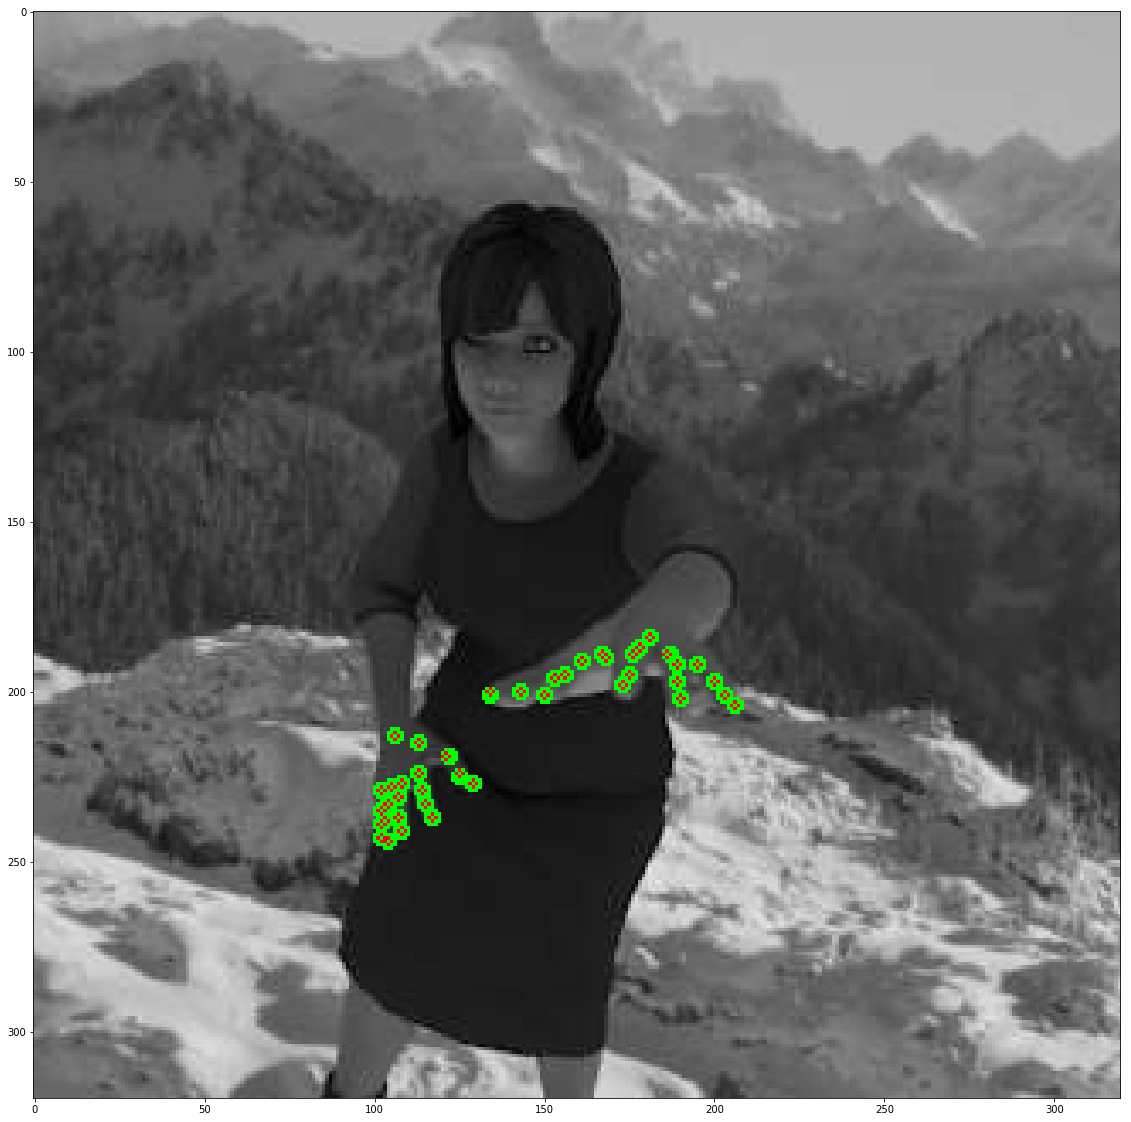

In [17]:
#f, subs = plt.subplots(len(images_show), 1, figsize=(15, 8*len(samples_to_check)))
#for c, im in enumerate(images_show):
#    subs[c].imshow(im)
    #subs[c].set_title(f"Confidence: {np.max(res[c][:,:,:,0])}")

f = plt.figure(figsize=(20, 20))
plt.imshow(images_show[0], cmap='gray')

In [18]:
arr = range(10)

for a in arr[:5]:
    print(a)

print()
    
for a in arr[5:]:
    print(a)

0
1
2
3
4

5
6
7
8
9
